# Прогнозирование музыкального жанра

**Описание полей данных**
- `instance_id` - уникальный идентификатор трека
- `track_name` - название трека
- `acousticness` - акустичность
- `danceability` - танцевальность
- `duration_ms` -продолжительность в милисекундах
- `energy` - энергичность
- `instrumentalness` - инструментальность
- `key` - базовый ключ (нота) произведения
- `liveness` - привлекательность
- `loudness` - громкость
- `mode` - указывает на модальность (мажорную или минорную) трека
- `speechiness` - выразительность
- `tempo` - темп
- `obtained_date` - дата загрузки в сервис
- `valence` - привлекательность произведения для пользователей сервиса
- `music_genre` - музыкальный жанр

## Данные

### Импорты

In [53]:
%pip install sweetviz
%pip install scikit-learn==1.1.3
%pip install catboost

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [113]:
import pandas as pd
import sweetviz as sv
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool, metrics, cv

from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    roc_auc_score,
    roc_curve,
    accuracy_score
)
from sklearn.utils import shuffle

from tqdm import tqdm
import matplotlib.pyplot as plt

In [55]:
train_data = pd.read_csv('/home/dolin/Music_genre_classification/kaggle_music_genre_train.csv')
test_data = pd.read_csv('/home/dolin/Music_genre_classification/kaggle_music_genre_test.csv')

submit_test = pd.read_csv('/home/dolin/Music_genre_classification/sample_submit.csv')

### Обзор данных

Напишем функцию для простого EDA

In [56]:
def info_df(df):
    plt.figure(figsize=(15, 13))
    sb.heatmap(df.corr(), cmap="YlGnBu", annot=True)
    print('------------------------------')
    print('| Информация о наборе данных |')
    print('------------------------------')
    df.info()
    print('------------------------------')
    print('| Первые 10 строчек датасета |')
    print('------------------------------')
    print(df.head(10))
    print('---------------------------------')
    print('| Последние 10 строчек датасета |')
    print('---------------------------------')
    print(df.tail(10))
    print('---------------------------')
    print('| Описательная статистика |')
    print('---------------------------')
    print(df.describe())
    print('--------------------')
    print('| Сумма дубликатов |')
    print('--------------------')
    print(df.duplicated().sum())
    print('--------------------------')
    print('| Ковариационная матрица |')
    print('--------------------------')
    plt.show()

------------------------------
| Информация о наборе данных |
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64

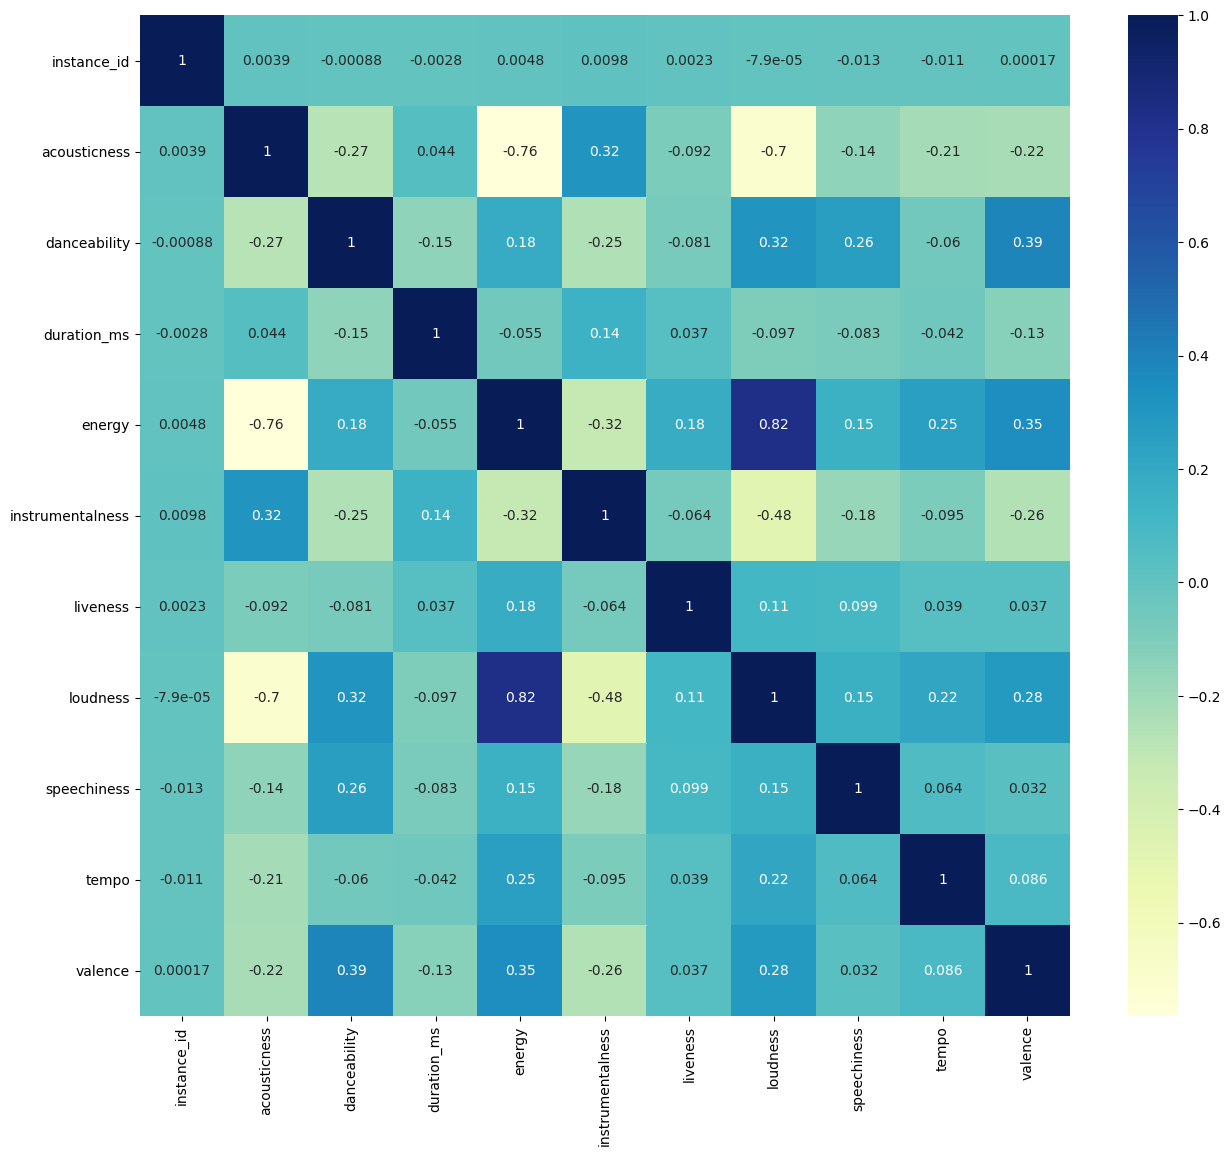

In [57]:
info_df(train_data)

------------------------------
| Информация о наборе данных |
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5099 entries, 0 to 5098
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       5099 non-null   int64  
 1   track_name        5099 non-null   object 
 2   acousticness      5099 non-null   float64
 3   danceability      5099 non-null   float64
 4   duration_ms       5099 non-null   float64
 5   energy            5099 non-null   float64
 6   instrumentalness  5099 non-null   float64
 7   key               4941 non-null   object 
 8   liveness          5099 non-null   float64
 9   loudness          5099 non-null   float64
 10  mode              4950 non-null   object 
 11  speechiness       5099 non-null   float64
 12  tempo             4978 non-null   float64
 13  obtained_date     5099 non-null   object 
 14  valence           5099 non-null   float64
d

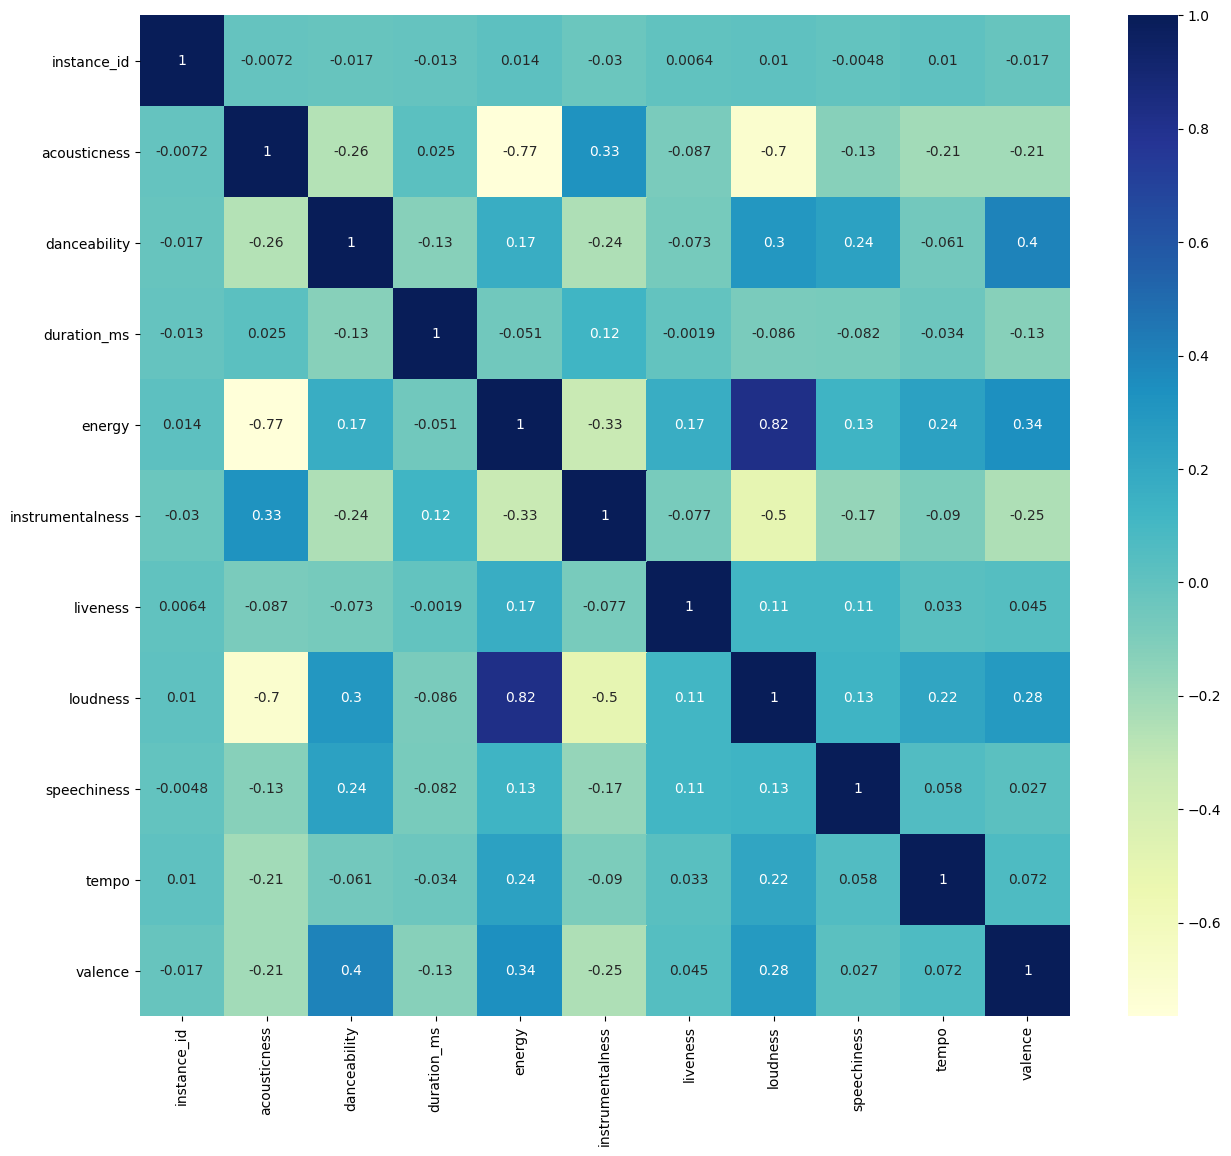

In [58]:
info_df(test_data)

Посмотрим на соотношение пропусков данных

In [59]:
print('---------------------------------')
print('| Proportion of missing values. |')
print('---------------------------------')
pd.DataFrame(round(train_data.isna().mean()*100,1)).style.background_gradient('coolwarm')

---------------------------------
| Proportion of missing values. |
---------------------------------


,0
instance_id,0.000000
track_name,0.000000
acousticness,0.000000
danceability,0.000000
duration_ms,0.000000
energy,0.000000
instrumentalness,0.000000
key,3.600000
liveness,0.000000
loudness,0.000000


In [60]:
print('---------------------------------')
print('| Proportion of missing values. |')
print('---------------------------------')
pd.DataFrame(round(test_data.isna().mean()*100,1)).style.background_gradient('coolwarm')

---------------------------------
| Proportion of missing values. |
---------------------------------


,0
instance_id,0.000000
track_name,0.000000
acousticness,0.000000
danceability,0.000000
duration_ms,0.000000
energy,0.000000
instrumentalness,0.000000
key,3.100000
liveness,0.000000
loudness,0.000000


### Константы

In [61]:
RANDOM_STATE = 1220

## Предобработка и исследовательский анализ данных

### Приведение типов данных

#### Явные и неявные дубликаты

Проверим наличие явных дубликатов

In [62]:
train_data = train_data.drop('instance_id',axis=1)
train_data.duplicated().sum()

1

In [63]:
test_data = test_data.drop('instance_id',axis=1)
test_data.duplicated().sum()

30

In [64]:
train_data = train_data.drop_duplicates().reset_index(drop=True)
# Удалять дубликаты мы не будем, дабы соблюсти размер датасета для проверки
# test_data = test_data.drop_duplicates().reset_index(drop=True)

Рассмотрим наличие неявных дубликатов

In [65]:
for i in ['key', 'mode', 'obtained_date', 'music_genre']:
    print(i)
    print('------------------------------------------------------------')
    print(train_data[i].unique())
    print('------------------------------------------------------------')

key
------------------------------------------------------------
['D' 'A' 'E' 'G#' 'C' 'D#' 'A#' 'F' 'F#' nan 'G' 'C#' 'B']
------------------------------------------------------------
mode
------------------------------------------------------------
['Major' 'Minor' nan]
------------------------------------------------------------
obtained_date
------------------------------------------------------------
['4-Apr' '3-Apr' '5-Apr' '1-Apr']
------------------------------------------------------------
music_genre
------------------------------------------------------------
['Country' 'Rock' 'Alternative' 'Hip-Hop' 'Blues' 'Jazz' 'Electronic'
 'Anime' 'Rap' 'Classical']
------------------------------------------------------------


In [66]:
for i in ['key', 'mode', 'obtained_date']:
    print(i)
    print('------------------------------------------------------------')
    print(test_data[i].unique())
    print('------------------------------------------------------------')

key
------------------------------------------------------------
['A#' 'G#' 'A' 'B' 'D' 'F#' 'F' 'G' 'C' nan 'D#' 'C#' 'E']
------------------------------------------------------------
mode
------------------------------------------------------------
['Minor' 'Major' nan]
------------------------------------------------------------
obtained_date
------------------------------------------------------------
['4-Apr' '3-Apr' '5-Apr' '1-Apr']
------------------------------------------------------------


#### Преобразование вещественных типов данных

In [67]:
train_data['duration_ms'] = train_data['duration_ms'].astype('int32')

test_data['duration_ms'] = test_data['duration_ms'].astype('int32')

#### Поиск аномальных значений

Взглянем еще раз на данные нашего тренировачного датасета

------------------------------
| Информация о наборе данных |
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20393 entries, 0 to 20392
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_name        20393 non-null  object 
 1   acousticness      20393 non-null  float64
 2   danceability      20393 non-null  float64
 3   duration_ms       20393 non-null  int32  
 4   energy            20393 non-null  float64
 5   instrumentalness  20393 non-null  float64
 6   key               19658 non-null  object 
 7   liveness          20393 non-null  float64
 8   loudness          20393 non-null  float64
 9   mode              19887 non-null  object 
 10  speechiness       20393 non-null  float64
 11  tempo             19951 non-null  float64
 12  obtained_date     20393 non-null  object 
 13  valence           20393 non-null  float64
 14  music_genre       20393 non-null  object 

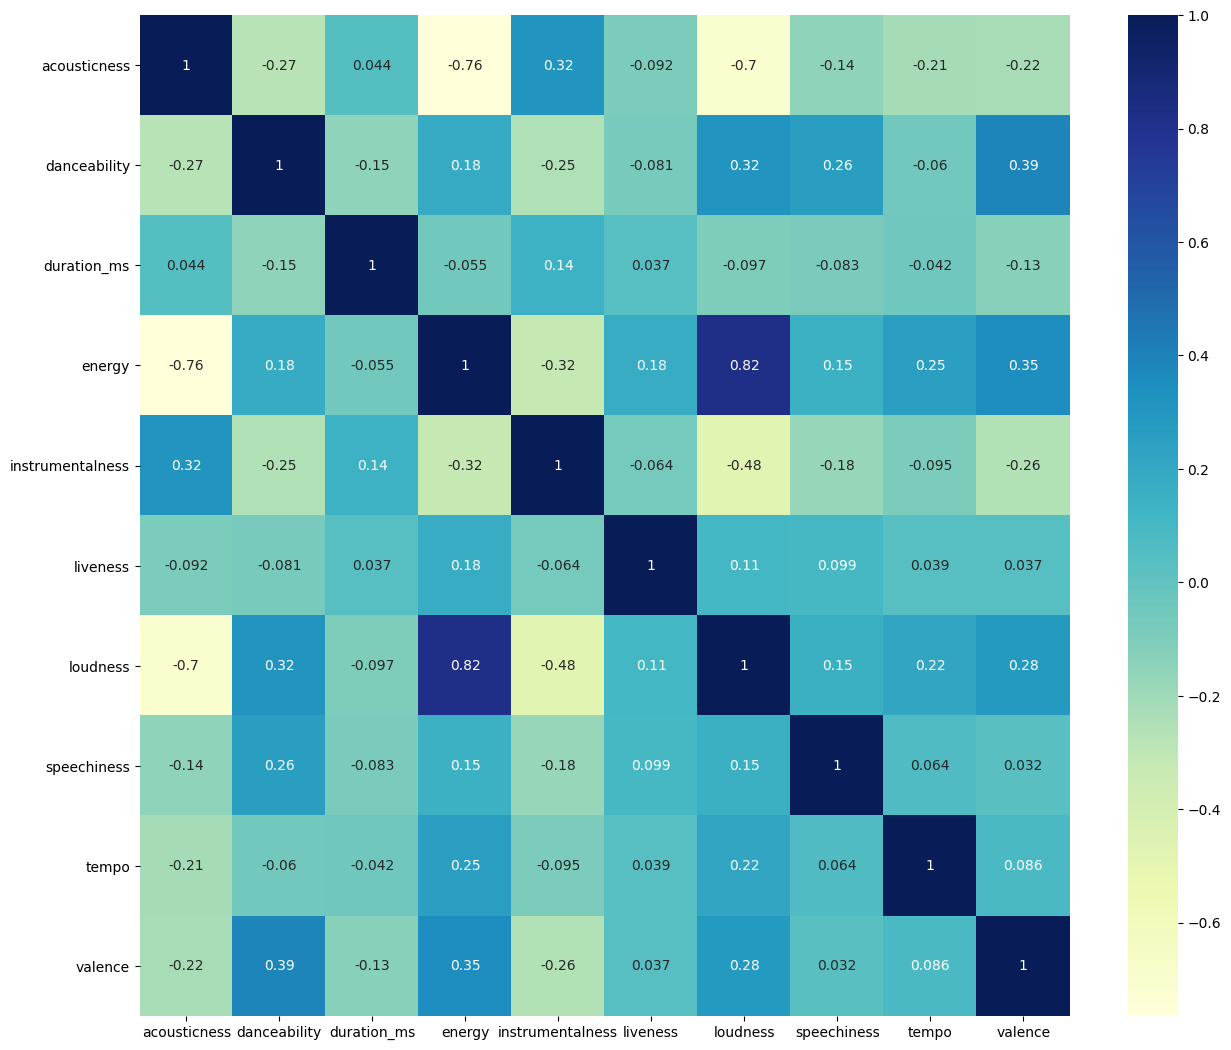

In [68]:
info_df(train_data)

Обратим внимание на длительность некоторых треков в -1 миллисекунду. Вариантов несколько: можно удалить все треки которые имеют такое значение и потерять кусочек данных, можно заменить медианным значением всех треков, а можно оставить как есть и перед обучением модели (после масштабирования признаков) занизить это значение, дабы оно не влияло на обучение

**Длительность трека**

Оценим экстремумы треков в датасете

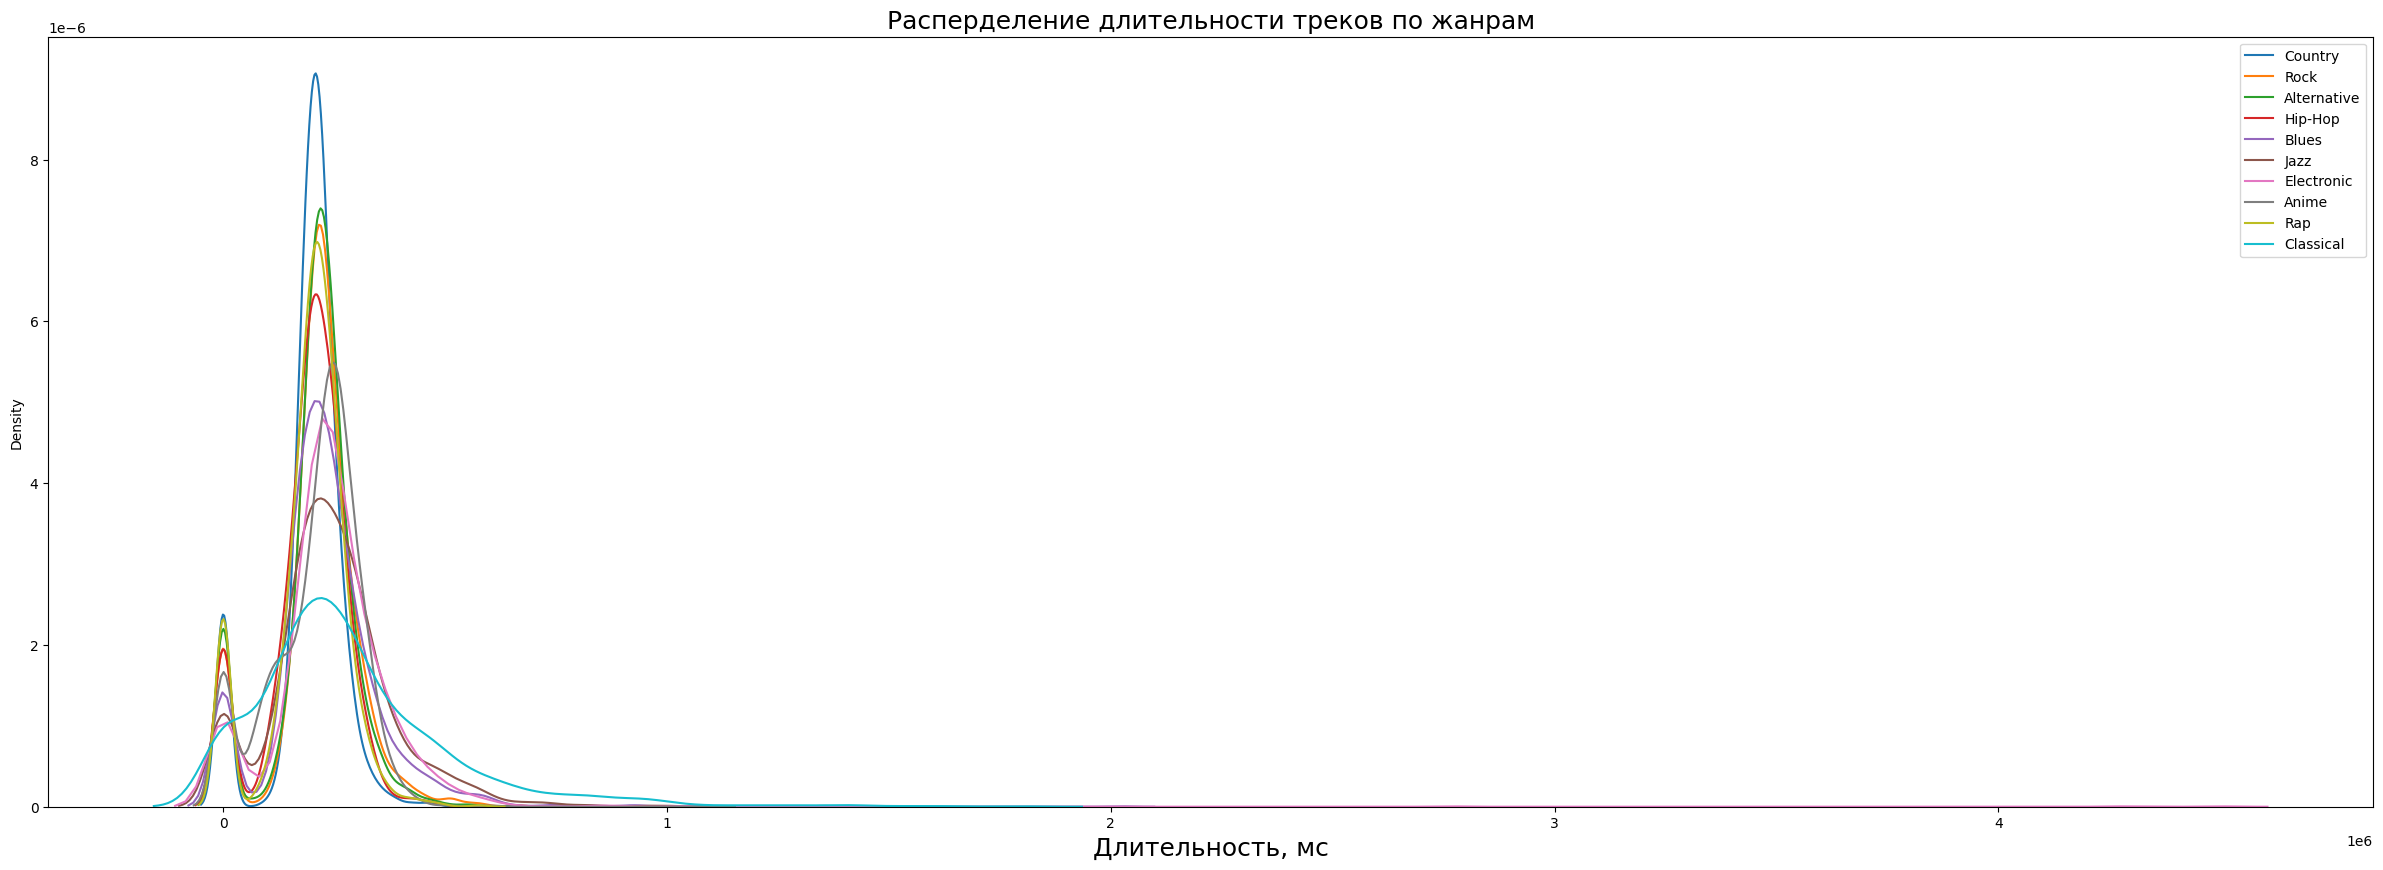

In [69]:
plt.figure(figsize=(30,10))
for genre in train_data['music_genre'].unique():
    sb.kdeplot(data=train_data.loc[train_data['music_genre']==genre, 'duration_ms'], label=genre)

plt.title("Расперделение длительности треков по жанрам", fontsize = 18)

plt.xlabel("Длительность, мс", fontsize = 18)
plt.legend();

Видно, что данные имеют аномальные значения. Особенно это видно на максимальной длительности трека. Возьмем ограничения в 2 стандартных отклонения

In [70]:
print((train_data.loc[train_data['duration_ms'] 
                < train_data['duration_ms']
               .std() * 0.95]
               .groupby('music_genre')['track_name']
               .agg({'count'})))

print('Всего треков:', (train_data.loc[train_data['duration_ms'] 
                < train_data['duration_ms']
               .std() * 0.95, 'track_name']
               .count()))

             count
music_genre       
Alternative    303
Anime          352
Blues          302
Classical      249
Country        218
Electronic     289
Hip-Hop        165
Jazz           154
Rap            316
Rock           234
Всего треков: 2582


Наибольшее количество коротких треков относится к жанрам:
- `Anime`
- `Rap`
- `Alternative`

In [71]:
print((train_data.loc[train_data['duration_ms'] 
                > train_data['duration_ms']
               .std() * 2]
               .groupby('music_genre')['track_name']
               .agg('count')))
print('Всего треков:', (train_data.loc[train_data['duration_ms'] 
                > train_data['duration_ms']
               .std() * 2, 'track_name']
               .count()))

music_genre
Alternative     672
Anime           693
Blues           987
Classical       654
Country         320
Electronic     1025
Hip-Hop         246
Jazz            533
Rap             484
Rock            607
Name: track_name, dtype: int64
Всего треков: 6221


А наибольшее количество долгих треков относится к жанрам:
- `Electronic`
- `Blues`
- `Anime`

Отберем только те треки длительность которых укладывается в заданый нами интервал и оценим расспределение длительности треков по жанрам

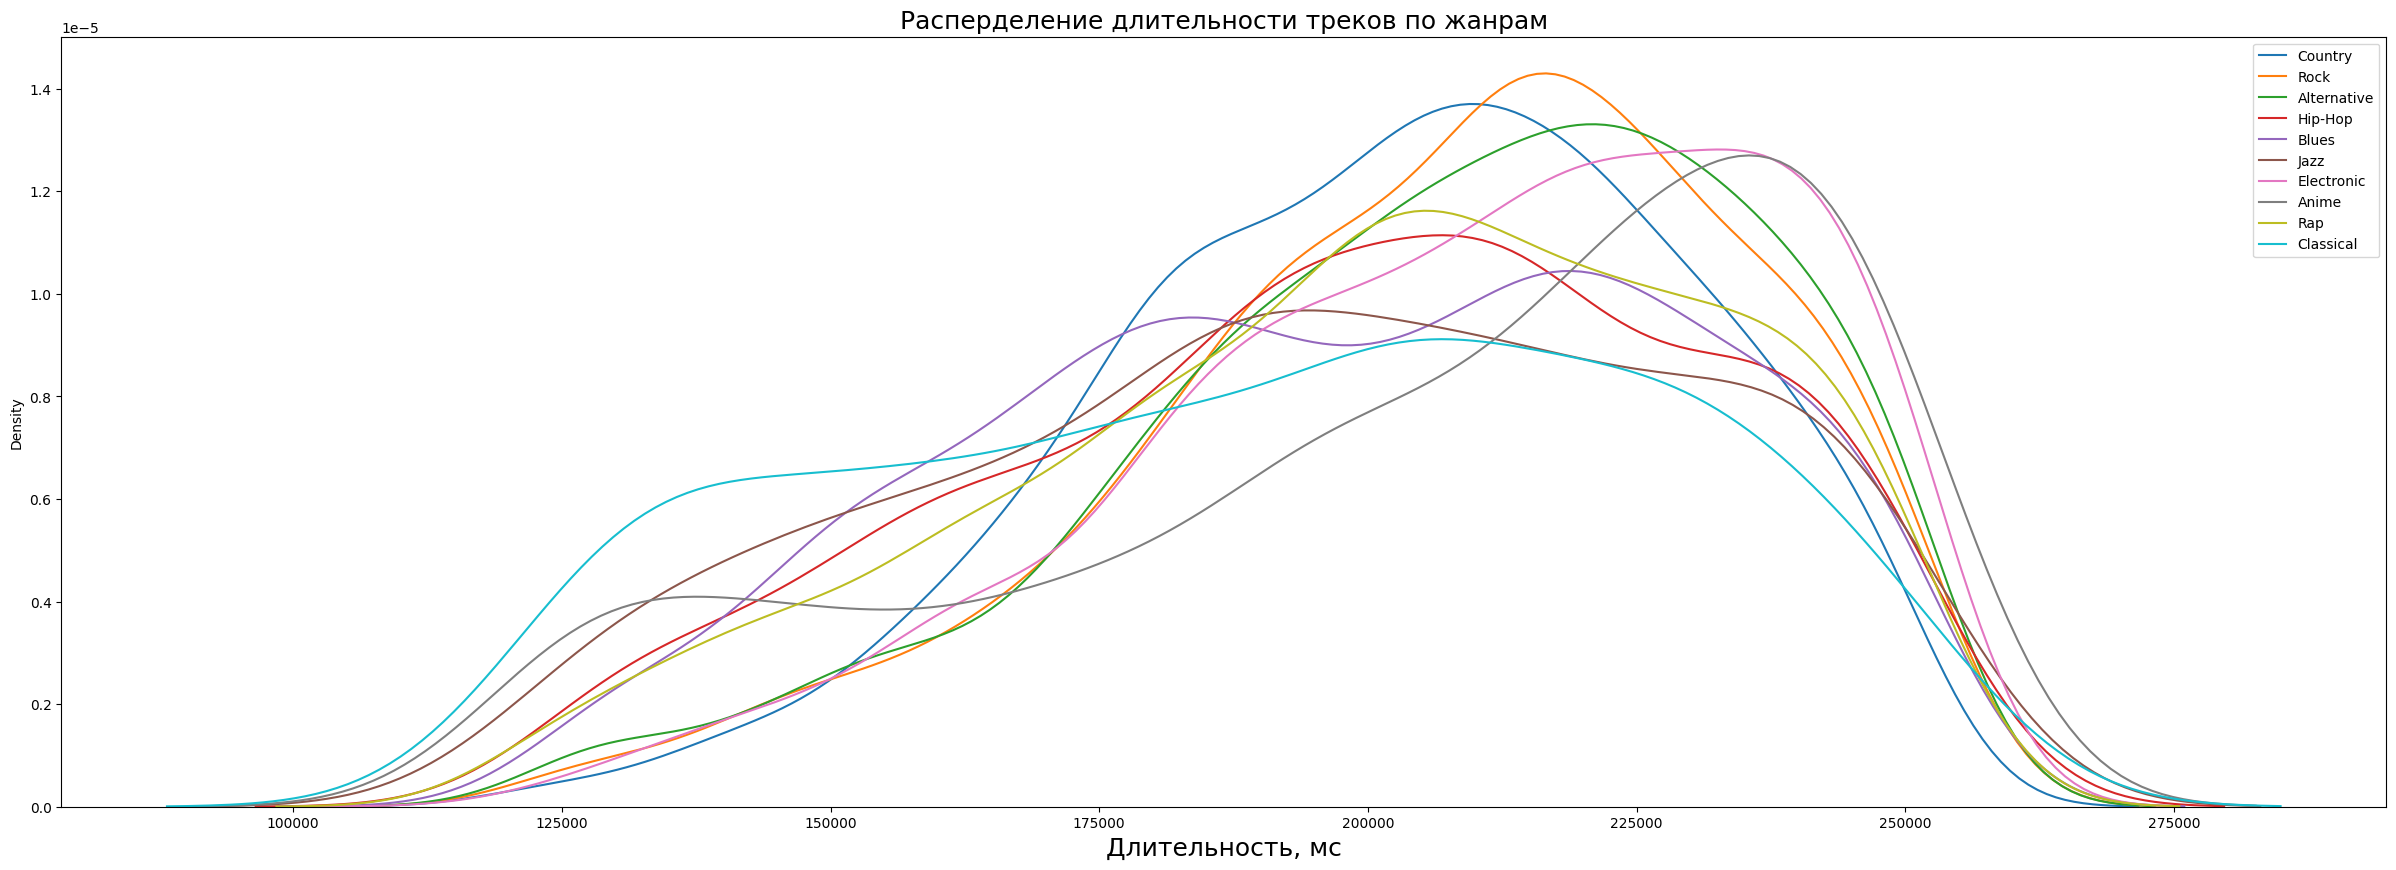

In [72]:
plt.figure(figsize=(30,10))
for genre in train_data['music_genre'].unique():
    sb.kdeplot(data=train_data.loc[(train_data['music_genre']==genre) & 
                                   ((train_data['duration_ms'] > train_data['duration_ms'].std() * 0.95) & 
                                    (train_data['duration_ms'] < train_data['duration_ms'].std() * 2)), 'duration_ms'], label=genre)

plt.title("Расперделение длительности треков по жанрам", fontsize = 18)

plt.xlabel("Длительность, мс", fontsize = 18)
plt.legend();

Создадим новый признак `duration_class` который будет являтся идентификатором длительности трека (до OHE: short, median, long)

In [73]:
def sml_train_songs(row):
    if row < train_data['duration_ms'].std() * 0.95:
        return 'short'
    elif row > train_data['duration_ms'].std() * 3:
        return 'long'
    else:
        return 'median'

In [74]:
def sml_test_songs(row):
    if row < test_data['duration_ms'].std() * 0.95:
        return 'short'
    elif row > test_data['duration_ms'].std() * 3:
        return 'long'
    else:
        return 'median'

In [75]:
train_data['duration_class'] = train_data['duration_ms'].apply(sml_train_songs)

In [76]:
test_data['duration_class'] = test_data['duration_ms'].apply(sml_test_songs)

**Привлекательность**

Рассмотрим корреляцию между параметрами `liveness` - привлекательность и `valence` - привлекательность произведения для пользователей сервиса.


In [77]:
train_data.corr()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
acousticness,1.000000,-0.273419,0.043785,-0.764948,0.316764,-0.091838,-0.699720,-0.144584,-0.214752,-0.221685
danceability,-0.273419,1.000000,-0.145351,0.182731,-0.253840,-0.080751,0.317235,0.257981,-0.059774,0.390221
duration_ms,0.043785,-0.145351,1.000000,-0.055474,0.141535,0.037051,-0.096944,-0.082700,-0.041716,-0.126994
energy,-0.764948,0.182731,-0.055474,1.000000,-0.319967,0.176772,0.821804,0.150509,0.250642,0.347975
instrumentalness,0.316764,-0.253840,0.141535,-0.319967,1.000000,-0.063751,-0.481398,-0.176946,-0.095373,-0.259975
liveness,-0.091838,-0.080751,0.037051,0.176772,-0.063751,1.000000,0.106565,0.098574,0.038922,0.037184
loudness,-0.699720,0.317235,-0.096944,0.821804,-0.481398,0.106565,1.000000,0.152087,0.220497,0.284014
speechiness,-0.144584,0.257981,-0.082700,0.150509,-0.176946,0.098574,0.152087,1.000000,0.064399,0.031584
tempo,-0.214752,-0.059774,-0.041716,0.250642,-0.095373,0.038922,0.220497,0.064399,1.000000,0.085628
valence,-0.221685,0.390221,-0.126994,0.347975,-0.259975,0.037184,0.284014,0.031584,0.085628,1.000000


Линейной зависимости от этих двух параметров не наблюдается. Оставим оба этих параметра и выберем наилучший путем рассчета значения Шэпли.

**Темп**

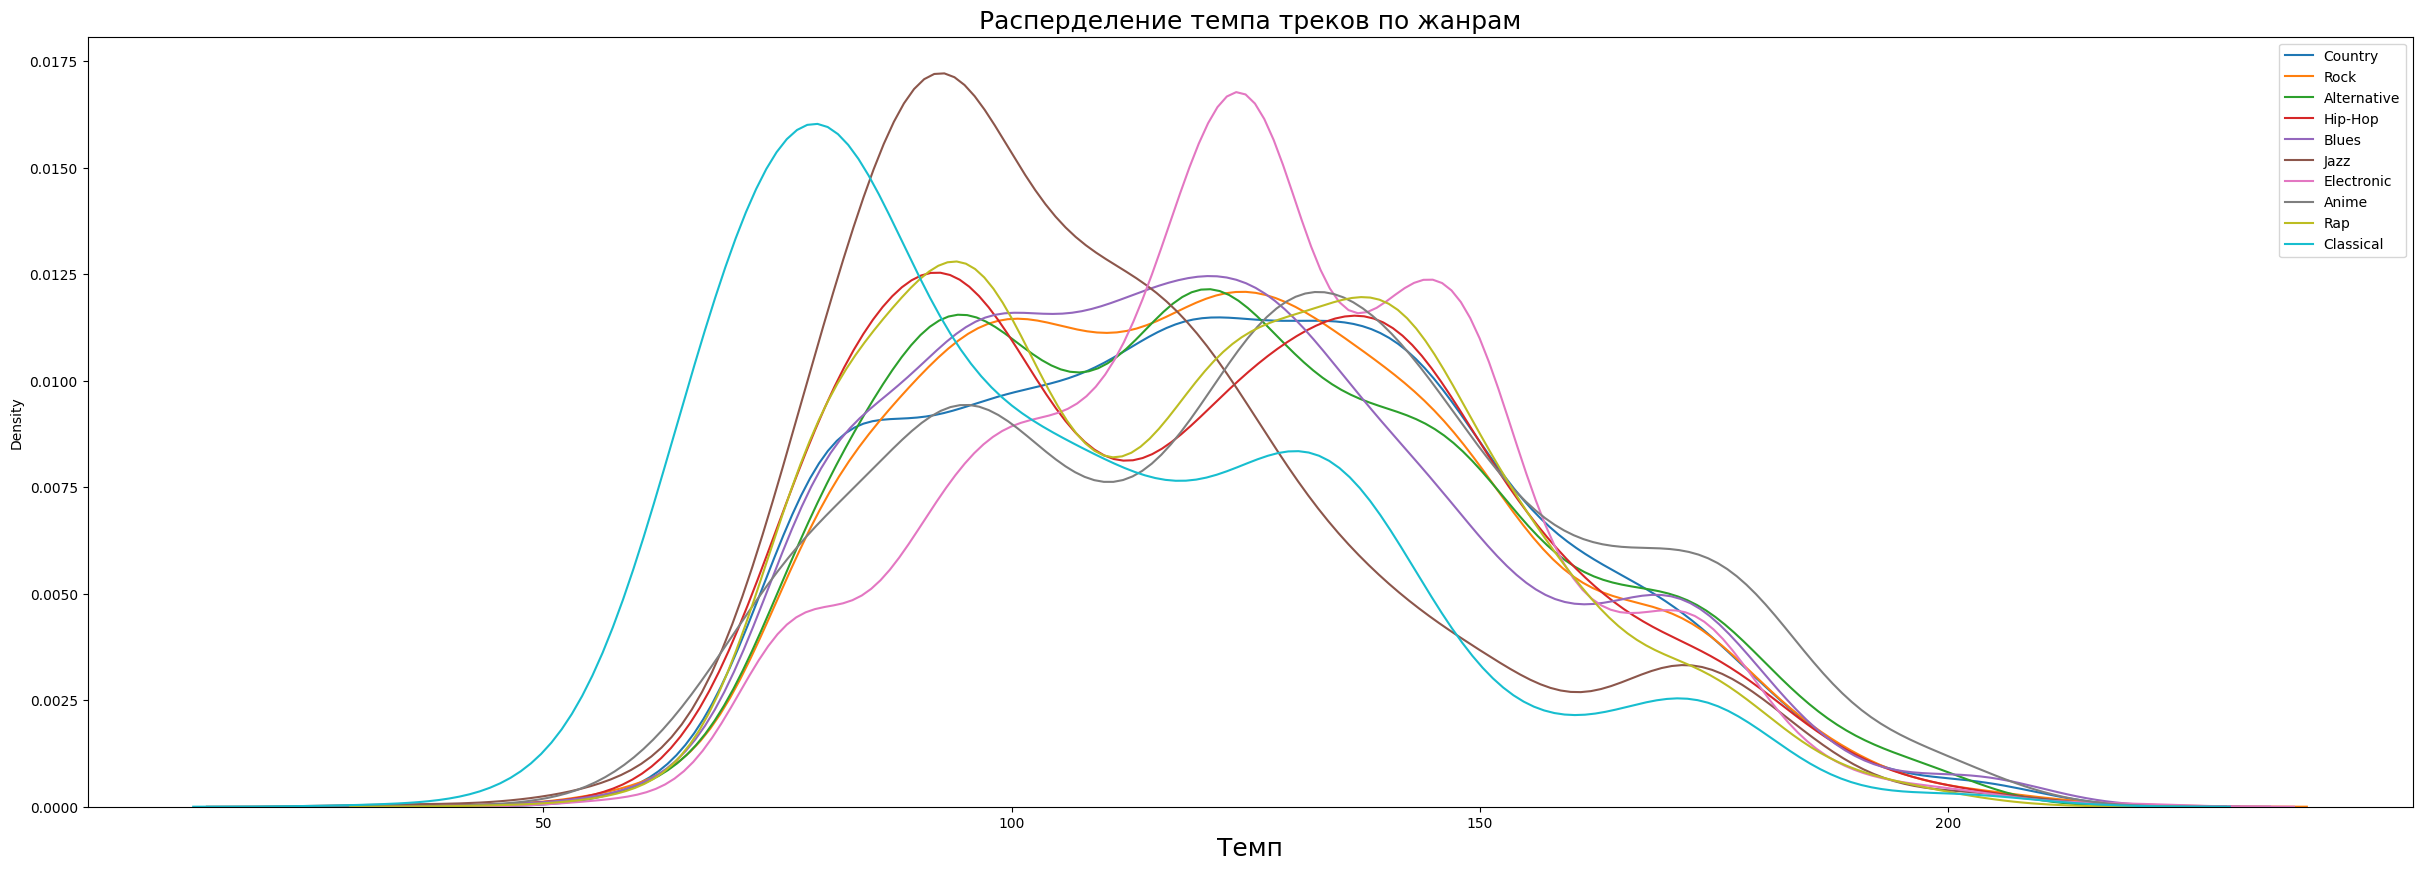

In [78]:
plt.figure(figsize=(30,10))
for genre in train_data['music_genre'].unique():
    sb.kdeplot(data=train_data.loc[(train_data['music_genre']==genre), 'tempo'], label=genre)

plt.title("Расперделение темпа треков по жанрам", fontsize = 18)

plt.xlabel("Темп", fontsize = 18)
plt.legend();

Можно отметить что для жанров Классической музыки, Джаза и Электронной  характерен высокий темп исполнения. Для заполнения пропусков в параметре Темп разделим медианное значение жанров Классика, Джаз, Электронная и оставшиеся жанры.

In [79]:
print('---------------------------------')
print('| Proportion of missing values. |')
print('---------------------------------')
pd.DataFrame(round(train_data.isna().mean()*100,1)).style.background_gradient('coolwarm')

---------------------------------
| Proportion of missing values. |
---------------------------------


,0
track_name,0.000000
acousticness,0.000000
danceability,0.000000
duration_ms,0.000000
energy,0.000000
instrumentalness,0.000000
key,3.600000
liveness,0.000000
loudness,0.000000
mode,2.500000


In [80]:
train_data.loc[(train_data['music_genre']=='Classical') & (train_data['tempo'].isna() == True), 'tempo'] = \
train_data.loc[(train_data['music_genre']=='Classical') & (train_data['tempo'].isna() == False), 'tempo'].median()

In [81]:
train_data.loc[(train_data['music_genre']=='Jazz') & (train_data['tempo'].isna() == True), 'tempo'] = \
train_data.loc[(train_data['music_genre']=='Jazz') & (train_data['tempo'].isna() == False), 'tempo'].median()

In [82]:
train_data.loc[(train_data['music_genre']=='Electronic') & (train_data['tempo'].isna() == True), 'tempo'] = \
train_data.loc[(train_data['music_genre']=='Electronic') & (train_data['tempo'].isna() == False), 'tempo'].median()

In [83]:
train_data.loc[(train_data['tempo'].isna() == True), 'tempo'] = \
train_data.loc[(train_data['tempo'].isna() == False), 'tempo'].median()

In [84]:
print('---------------------------------')
print('| Proportion of missing values. |')
print('---------------------------------')
pd.DataFrame(round(train_data.isna().mean()*100,1)).style.background_gradient('coolwarm')

---------------------------------
| Proportion of missing values. |
---------------------------------


,0
track_name,0.000000
acousticness,0.000000
danceability,0.000000
duration_ms,0.000000
energy,0.000000
instrumentalness,0.000000
key,3.600000
liveness,0.000000
loudness,0.000000
mode,2.500000


# Подготовка признаков

Исследуем четыре модели `DecisionTreeClassifier`, `RandomForestClassifier`, `LogisticRegression` и `CatBoost`. 

In [85]:
train_data = train_data.drop(['track_name'], axis=1)
test_data = test_data.drop(['track_name'], axis = 1)

In [86]:
features = train_data.drop('music_genre', axis = 1)
target = train_data['music_genre']

test_features = test_data
test_target = submit_test['music_genre']



test_features = test_features.fillna(-999)
test_features = test_features.fillna(-999)

In [87]:
ohe_features = features.select_dtypes(include='object').columns.to_list()
print(ohe_features)
num_features = features.select_dtypes(exclude='object').columns.to_list()
num_features

['key', 'mode', 'obtained_date', 'duration_class']


['acousticness',
 'danceability',
 'duration_ms',
 'energy',
 'instrumentalness',
 'liveness',
 'loudness',
 'speechiness',
 'tempo',
 'valence']

In [88]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

encoder_ohe.fit(features[ohe_features])

features[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features[ohe_features])

features = features.drop(ohe_features, axis=1)

In [89]:
test_features[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(test_features[ohe_features])

test_features = test_features.drop(ohe_features, axis=1)

/home/dolin/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [90]:
scaler = StandardScaler()
features[num_features] = scaler.fit_transform(features[num_features])

scaler.fit(pd.DataFrame(features[num_features]))

StandardScaler()

In [91]:
features[num_features] = scaler.transform(features[num_features])
test_features[num_features] = scaler.transform(test_features[num_features])

In [94]:
features.head(10)

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,...,key_G,key_G#,key_nan,mode_Minor,mode_nan,obtained_date_3-Apr,obtained_date_4-Apr,obtained_date_5-Apr,duration_class_median,duration_class_short
0,0.638012,0.628378,-0.297676,-1.091690,-0.464588,-0.500984,-1.507123,-0.460947,-0.647468,-0.059960,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,-0.098830,-0.639819,-0.262325,0.178026,-0.521844,-0.542966,0.029265,-0.574519,-0.259426,0.305715,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,-0.145466,-0.628184,-0.370312,0.711386,-0.522010,-0.105158,0.605092,2.861301,-1.324939,-0.495483,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,-0.680843,1.658061,0.280995,0.986027,-0.521999,0.758462,0.681457,-0.112044,-0.161942,2.060134,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,-0.148575,1.047232,-0.197620,-0.200103,-0.522004,-0.135145,0.546001,-0.436391,-1.473887,0.486498,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
5,-0.537205,-1.477527,1.361308,-0.140398,0.688427,-0.518976,-0.572744,-0.581681,0.825876,0.129041,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,-0.853600,0.541117,-0.016650,0.245691,-0.521932,-0.669510,-0.588381,-0.589867,0.100891,-0.220200,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
7,2.108588,0.168802,0.705731,-2.054923,0.642750,-0.638324,-1.713126,-0.475271,0.322487,-0.285939,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
8,-0.248064,0.494578,0.497096,-0.120496,-0.521625,-0.417021,0.024901,-0.590890,-1.574027,0.334476,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
9,-0.753905,-0.145338,0.131171,1.340274,0.107678,-0.243098,1.055281,0.303365,1.299781,-0.142134,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [108]:
%%time
LogisticRegression_model = None
LogisticRegression_f1_mean_cv = 0
mi = 0

for mit in tqdm(range(100, 1100, 10)):
    model = LogisticRegression(random_state = RANDOM_STATE, solver='newton-cg', 
                                class_weight='balanced', max_iter=mit, multi_class='multinomial')
    model.fit(features, target)
    f1_mean_cv = cross_val_score(model, features, target,cv=5,scoring = "balanced_accuracy").mean()
    if f1_mean_cv > LogisticRegression_f1_mean_cv:
        LogisticRegression_model = model
        LogisticRegression_f1_mean_cv = f1_mean_cv
        mi = mit

100%|██████████| 100/100 [14:20<00:00,  8.60s/it]

CPU times: user 1h 8min 9s, sys: 1h 43min 47s, total: 2h 51min 57s
Wall time: 14min 20s


In [110]:
print(f'Model hyperparameters: max_iter = {mi}')
print("Cross validation Balanced_Accuracy-mean", LogisticRegression_f1_mean_cv)

Model hyperparameters: max_iter = 100
Cross validation Balanced_Accuracy-mean 0.3980002281951864


In [114]:
print("Confusion matrix")
print(confusion_matrix(test_target, LogisticRegression_model.predict(test_features)))
print("Accuracy:",accuracy_score(test_target, LogisticRegression_model.predict(test_features)))

Confusion matrix
[[  0   0   0   9   0 492   0   1   0   0]
 [  0   0   0   8   0 517   0   1   0   0]
 [  0   0   0   9   0 491   0   3   0   0]
 [  0   0   0  14   0 490   0   0   0   0]
 [  0   0   0  10   0 521   0   1   0   0]
 [  0   0   0  12   0 515   0   2   0   0]
 [  0   0   0  11   0 505   0   1   0   0]
 [  0   0   0  16   0 482   0   0   0   0]
 [  0   0   0   7   0 496   0   1   0   0]
 [  0   0   0  10   0 473   0   1   0   0]]
Accuracy: 0.10374583251617964


In [104]:
%%time

DecisionTreeClassifier_model = None
DecisionTreeClassifier_ac_mean_cv = 0
ms = 0
de = 0

for msl in tqdm(range(2, 6, 2)):
    for depth in range(1, 101):
        model = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=depth,
                                       min_samples_leaf = msl, class_weight='balanced') 
        model.fit(features, target)
        ac_mean_cv = cross_val_score(model, features, target,cv=5,scoring = "f1").mean()
        if ac_mean_cv > DecisionTreeClassifier_ac_mean_cv:
            DecisionTreeClassifier_model = model
            DecisionTreeClassifier_ac_mean_cv = ac_mean_cv
            ms = msl
            de = depth

  0%|          | 0/2 [00:00<?, ?it/s]/home/dolin/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dolin/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/dolin/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/dolin/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/home/dolin/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1136, in f1_score


KeyboardInterrupt: 

In [99]:
print(f'Model hyperparameters: min_samples_leaf = {ms}; max_depth = {de}')
print('Cross validation Accuracy-mean', DecisionTreeClassifier_ac_mean_cv)

Model hyperparameters: min_samples_leaf = 4; max_depth = 11
Cross validation Accuracy-mean 0.37169652429740674
